## libstempo tutorial: basic functionality

#### Michele Vallisneri, vallis@vallis.org; latest revision: 2014/12/12 for v2 API

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from __future__ import print_function
import sys, math, numpy as N, matplotlib.pyplot as P

Load the libstempo Python extension. It requires a source installation of tempo2, as well as current Python and compiler, and the numpy and Cython packages.

(Both Python 2.7 and 3.4 are supported; this means that in Python 2.7 all returned strings will be unicode strings, while in Python 3 all function arguments should be default unicode strings rather than `bytes`. This should work transparently, although there are limitations to what characters can be passed to tempo2; you should probably restrain yourself to ASCII.

In [3]:
from libstempo.libstempo import *

In [4]:
import libstempo as T

T.data = T.__path__[0] + '/data/' # example files

In [5]:
print("Python version   :",sys.version.split()[0])
print("libstempo version:",T.__version__)
print("Tempo2 version   :",T.libstempo.tempo2version())

Python version   : 3.4.3
libstempo version: 2.2.3
Tempo2 version   : 1.100


We load a single-pulsar object. Doing this will automatically run the tempo2 fit routine once.

In [6]:
psr = T.tempopulsar(parfile = T.data + '/J1909-3744_NANOGrav_dfg+12.par',
                    timfile = T.data + '/J1909-3744_NANOGrav_dfg+12.tim',units=True)

Let's start simple: what is the name of this pulsar? (You can change it, by the way.)

In [8]:
psr.name

'1909-3744'

Next, let's look at observations: there are `psr.nobs` of them; we can get numpy arrays of the site TOAs [in MJDs] with `psr.stoas`, of the TOA measurement errors [in microseconds] with `psr.toaerrs`, and of the measurement frequencies with `psr.freqs`. These arrays are *views* of the tempo2 data, so you can write to them (but you cannot currently change the number of observations).

In [9]:
psr.nobs

1001

(When `units` are active, site TOAs are represented as dimensionless numbers since they are not in one of the recognized `astropy` time scales.)

In [11]:
psr.stoas

array([ 53292.017,  53292.048,  53355.834, ...,  54641.173,  54706.993,
        54764.835], dtype=float128)

In [12]:
psr.toaerrs

<Quantity [ 1.231, 4.668, 0.453,...,  0.158, 1.336, 0.316] us>

In [13]:
psr.freqs

<Quantity [ 1372., 1372., 1372.,...,   884.,  884.,  884.] MHz>

By contrast, barycentric TOAs and frequencies are computed on the basis of current pulsar parameters, so you get them by calling `psr` *methods* (with parentheses), and you get a *copy* of the current values. Writing to it has no effect on the tempo2 data.

In [18]:
psr.toas()

<Time object: scale='tt' format='mjd' value=[ 53292.01663801  53292.04820909  53355.82916309 ...,  54641.1796227
  54706.99748746  54764.83381846]>

In [19]:
psr.ssbfreqs()

<Quantity [ 1372.13132715, 1372.13155182, 1372.04346329,...,
             883.9829272 ,  884.06611515,  884.08003698] MHz>

Residuals (in seconds) are returned by residuals(). The method takes a few options... I'll let its docstring help describe them. libstempo is fully documented in this way (try `help(T.tempopulsar)`). 

In [14]:
help(psr.residuals)

Help on built-in function residuals:

residuals(...) method of libstempo.libstempo.tempopulsar instance
    tempopulsar.residuals(updatebats=True,formresiduals=True,removemean=True)
    
    Returns residuals as a numpy.longdouble array (a copy of current values).
    Will update TOAs/recompute residuals if `updatebats`/`formresiduals` is True
    (default for both). Will remove residual mean if `removemean` is True;
    first residual if `removemean` is 'first'; weighted residual mean
    if `removemean` is 'weighted'.



In [20]:
psr.residuals()

<Quantity [-1.1791214e-07, 7.1732111e-06, 1.0669843e-06,...,
            4.0526495e-07, 1.4199455e-06,-4.9929815e-07] s>

We can plot TOAs vs. residuals, but we should first sort the arrays; otherwise the array follow the order in the tim file, which may not be chronological.

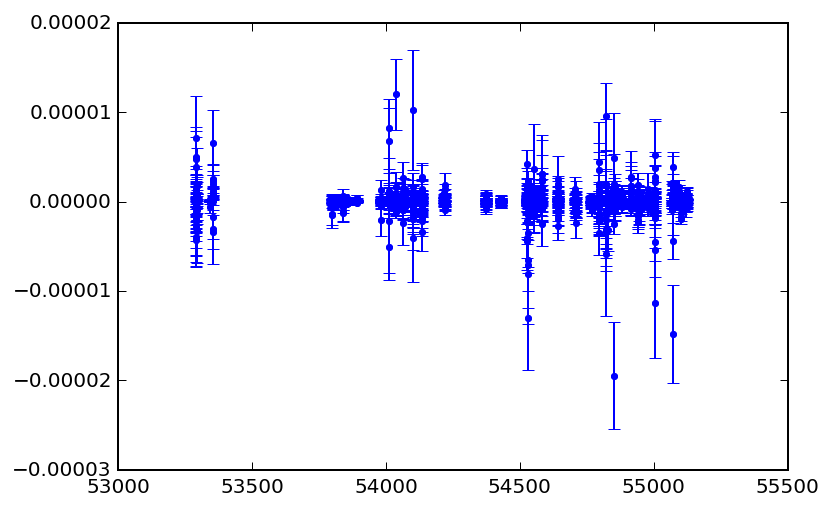

In [41]:
# get sorted array of indices
i = N.argsort(psr.toas().mjd)
# use numpy fancy indexing to order residuals 
P.errorbar(psr.toas().mjd[i],
           psr.residuals()[i].value,
           yerr=1e-6*psr.toaerrs[i].value,
           fmt='.');

We can also see what flags have been set on the observations, and what their values are. The latter returns a numpy vector of strings. *Flags are not currently writable.*

In [42]:
psr.flags()

['fe', 'be', 'B', 'bw', 'tobs', 'pta', 'proc', 'chanid']

In [43]:
psr.flagvals('chanid')

array(['gasp_1372', 'gasp_1372', 'gasp_1372', ..., 'gasp_884', 'gasp_884',
       'gasp_884'], 
      dtype='|S32')

In fact, there's a commodity routine in `libstempo.plot` to plot residuals, taking flags into account.

In [44]:
import libstempo.plot as LP

LP.plotres(psr,group='B')

TypeError: Only dimensionless scalar quantities can be converted to Python scalars

Timing-model parameters can be accessed by using psr as a Python dictionary. Each parameter is a special object with properties `val`, `err` (as well as `fit`, which is true is the parameter is currently being fitted, and `set`, which is true if the parameter was assigned a value).

In [10]:
psr['RAJ'].val, psr['RAJ'].err, psr['RAJ'].fit, psr['RAJ'].set

(<Quantity 5.0169080674060326785 rad>,
 <Quantity 7.7537595250585651792e-10 rad>,
 True,
 True)

The names of all fitted parameters, of all set parameters, and of *all* parameters are returned by `psr.pars(which='fit')`. We show only the first few.

In [11]:
fitpars = psr.pars() # defaults to fitted parameters
setpars = psr.pars(which='set')
allpars = psr.pars(which='all')

print(len(fitpars),len(setpars),len(allpars))
print(fitpars[:10])

82 157 1942
('RAJ', 'DECJ', 'F0', 'F1', 'PMRA', 'PMDEC', 'PX', 'SINI', 'PB', 'A1')


The number of fitting parameters is psr.ndim.

In [23]:
psr.ndim

82

Changing the parameter values results in different residuals.

In [7]:
# look +/- 3 sigmas around the current value
x0, dx = psr['RAJ'].val, psr['RAJ'].err
xs = x0 + dx * N.linspace(-3,3,20)         

res = []
for x in xs:
    psr['RAJ'].val = x
    res.append(psr.rms()/1e-6)
psr['RAJ'].val = x0                       # restore the original value

P.plot(xs,res)

TypeError: Only dimensionless scalar quantities can be converted to Python scalars

In [7]:
psr.vals()

array([<Quantity 5.0169080674060326785 rad>,
       <Quantity -0.65864032508411707312 rad>,
       <Quantity 339.3156927586801522 Hz>,
       <Quantity -1.6148002837260219042e-15 Hz / s>,
       <Quantity -9.6131471013527717579 mas / yr>,
       <Quantity -35.535142282332215051 mas / yr>,
       <Quantity 0.089434981481806251577 mas>,
       <Quantity 0.99887143074446215385>,
       <Quantity 1.5334494513051029191 d>,
       <Quantity 1.897991023852069233 lightsecond>,
       <Quantity 53113.950587082067369 d>,
       <Quantity -3.4172897686213263339e-08>,
       <Quantity -2.6426180555364916833e-07>,
       <Quantity 0.21308376259512886794 solMass>,
       <Quantity -0.00026660259649978304921>,
       <Quantity -0.00059065284874180338237>,
       <Quantity -0.00075267150029576306045>,
       <Quantity -0.00081078205801421796559>,
       <Quantity -0.00094057688388278449972>,
       <Quantity -0.00083853592921790342804>,
       <Quantity -0.00081896528177834817099>,
       <Quantity -0

We can also call the tempo2 fitting routine, which will fit around the current parameter values, replacing them with their new best values. Individual parameters can be included or excluded in the fitting by setting their 'fit' field

In [8]:
psr['DM'].fit

False

In [9]:
psr['DM'].fit = True
print(psr['DM'].val)

10.39468 pc / cm3


In [10]:
psr.fit()

In [11]:
print(psr['DM'].val,psr['DM'].err)

12.5078114702 pc / cm3 3.41819660798 pc / cm3


The tempo2-computed chi squared and rms is available as `psr.fitchisq`; it can also be recomputed by `psr.chisq()` (which evaluates `N.sum(psr.residuals()**2 / (1e-12 * psr.toaerrs**2))`). 

The pulsar parameters can be read in bulk by calling `psr.vals(which='fit')`, which will default to fitted parameters, but can also be given `'all'`, `'set'`, or even a list of parameter names.

In [12]:
fitvals = psr.vals()
print(fitvals)

[<Quantity 5.0169080673899805606 rad>
 <Quantity -0.65864032473497550129 rad> <Quantity 339.31569275867931573 Hz>
 <Quantity -1.6147937701969167847e-15 Hz / s>
 <Quantity 12.507811470162678216 pc / cm3>
 <Quantity -9.6108456556012873979 mas / yr>
 <Quantity -35.56455877732183549 mas / yr>
 <Quantity 0.11952140049470966916 mas> <Quantity 0.99879945929035872929>
 <Quantity 1.5334494513074447082 d>
 <Quantity 1.8979910297456268894 lightsecond>
 <Quantity 53113.950587079225834 d> <Quantity -4.1787076378388282255e-08>
 <Quantity -2.7312087415492985285e-07>
 <Quantity 0.2126685865670313987 solMass>
 <Quantity -0.00046597778562144276902> <Quantity -0.0013590879527967021241>
 <Quantity -0.0015749376737665024519> <Quantity -0.001585236574170599323>
 <Quantity -0.0015549368355307930281> <Quantity -0.00091965330452504990266>
 <Quantity -0.00083851044181039138104>
 <Quantity -0.00084044504440923822799> <Quantity -0.0012948886186572300068>
 <Quantity -0.0013259037001562784456> <Quantity -0.00179228

In [13]:
psr.vals(which=['RAJ','DECJ','PMRA'])

array([<Quantity 5.0169080673899805606 rad>,
       <Quantity -0.65864032473497550129 rad>,
       <Quantity -9.6108456556012873979 mas / yr>], dtype=object)

To set parameter values in bulk, you give a first argument to `vals`. Or call it with a dictionary. 

In [14]:
psr.vals([5.1,-0.6],which=['RAJ','DECJ','PMRA'])
psr.vals({'PMRA': -9.5})

print(psr.vals(which=['RAJ','DECJ','PMRA']))

# restore original values
psr.vals(fitvals)

[<Quantity 5.0999999999999996447 rad> <Quantity -0.5999999999999999778 rad>
 <Quantity -9.5 mas / yr>]


Be careful about loss of precision; `tempopar.val` is a numpy longdouble, so you should be careful about assigning it a regular Python double. By contrast, doing arithmetics with numpy longdoubles will preserve their nature and precision.

You can access errors in a similar way with `psr.errs(...)`.

It's also possible to obtain the design matrix computed at the current parameter values, which has shape `psr.nobs * (len(psr.pars) + 1)`, since a constant offset is always included among the fitting parameters.

In [15]:
d = psr.designmatrix()

ValueError: setting an array element with a sequence.

These, for instance, are the derivatives with respect to RAJ and DECJ, evaluated at the TOAs.

In [16]:
# we need the sorted-index array compute above
P.plot(psr.toas()[i]/365.25,d[i,1],'-x'); P.hold(True)
P.plot(psr.toas()[i]/365.25,d[i,2],'-x')

NameError: name 'i' is not defined

It's easy to save the current timing-model to a new par file. Omitting the argument will overwrite the original parfile.

In [34]:
psr.savepar('./foo.par')

In [35]:
!head foo.par

PSRJ           1909-3744
RAJ             19:09:47.4380320         1  0.00001067127248211017   
DECJ           -37:44:14.31897           1  0.00045632647959166725   
F0             339.31569275867931573     1  0.00000000000381382122   
F1             -1.6147937701969167847e-15 1  3.2219023837179870291e-20
PEPOCH         53000                       
POSEPOCH       53000                       
DMEPOCH        53000                       
DM             12.507811470162678216     1  3.41819660797695590304   
PMRA           -9.6108456556012873979    1  0.03081020419650991327   


Same for writing tim files.

In [36]:
psr.savetim('./foo.tim')

In [37]:
!head foo.tim

FORMAT 1
MODE 1
 53292.000004.1.000.000.tsum 1372.00000000 53292.01653552588140172 1.23100 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53292.000010.1.000.000.tsum 1372.00000000 53292.04810962983469835 4.66800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 901.322 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53355.000005.1.000.000.tsum 1372.00000000 53355.83359727578050169 0.45300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 1081.587 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53800.000018.1.000.000.tsum 1372.00000000 53800.48353665754979858 0.14800 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3424.969 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53838.000020.1.000.000.tsum 1372.00000000 53838.37506136744340068 0.54300 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -tobs 3064.446 -pta NANOGrav -proc dfg+12 -chanid gasp_1372 
 53858.000028.1.000.000.tsum 1372.00000000 53858.31918408581089963 0.08900 gbt -fe Rcvr1_2 -be GASP -B L -bw 4.0 -to

With libstempo, it's easy to replicate some of the "toasim" plugin functionality. By subtracting the residuals from the site TOAs (psr.stoas, vs. the barycentered psr.toas) and refitting, we can create a "perfect" timing solution. (Note that 1 ns is roughly tempo2's claimed accuracy.)

In [38]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

1.7908760868040159


In [39]:
psr.stoas[:] -= psr.residuals() / 86400.0
psr.fit()

In [40]:
print(math.sqrt(N.mean(psr.residuals()**2)) / 1e-6)

0.00020173807674486906


Then we can add, e.g., homoskedastic white measurement noise at 100 ns (remember the tempo units: days for TOAs, us for errors, s for residuals).

In [17]:
psr.stoas[:] += 0.1e-6 * N.random.randn(psr.nobs) / 86400.0
psr.toaerrs[:] = 0.1
psr.fit()

UnitConversionError: '' (dimensionless) and 'us' (time) are not convertible

<Container object of 3 artists>

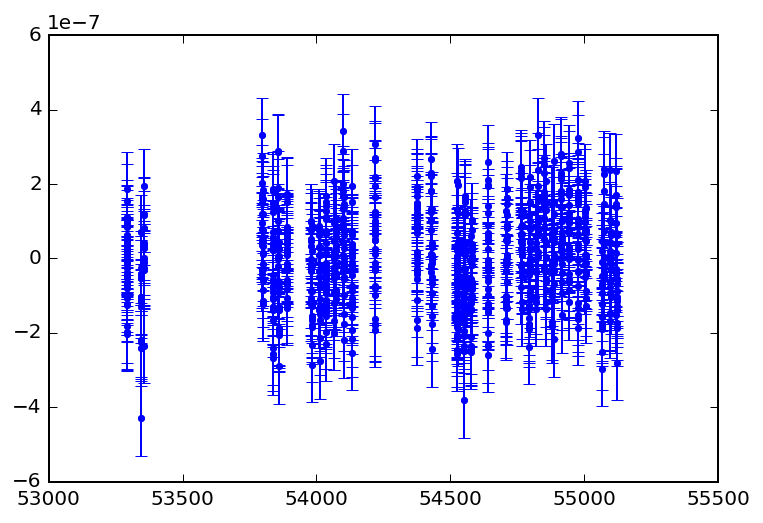

In [42]:
i = N.argsort(psr.toas())
P.errorbar(psr.toas()[i],psr.residuals()[i],yerr=1e-6*psr.toaerrs[i],fmt='.')